In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
# Define paths to the dataset
train_dir = "../../../Data/images/train"
# validation_dir = "../../../Data/images/"

# Image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
INITIAL_EPOCHS = 20 # Set a higher number, EarlyStopping will find the best epoch
FINE_TUNE_EPOCHS = 50 # Epochs for the fine-tuning phase



# Create a single ImageDataGenerator for data augmentation, normalization,
# and splitting the data into training and validation sets.
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of the data for validation
)

# Create the training data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb', # MobileNetV2 requires 3 color channels
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training', # Specify this is the training set
    seed=42
)

# Create the validation data generator
validation_generator = datagen.flow_from_directory(
    train_dir, # Same directory as training
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb', # MobileNetV2 requires 3 color channels
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation', # Specify this is the validation set
    seed=42
)

# Get class labels
class_labels = list(train_generator.class_indices.keys())
print("Class Labels:", class_labels)

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Class Labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:

local_weights_path = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

# Load the base MobileNetV2 model, excluding the top classification layer
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze the base model initially
base_model.trainable = False

# Add our custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_labels), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Display the model architecture
model.summary()

2025-10-10 03:15:40.414312: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,576,903 (13.64 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
print("\n--- PHASE 1: INITIAL TRAINING OF THE HEAD ---\n")

# Compile the model for the first phase
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for robust training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train only the top layers
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)



--- PHASE 1: INITIAL TRAINING OF THE HEAD ---

Epoch 1/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 490s 678ms/step - accuracy: 0.4256 - loss: 1.4903 - val_accuracy: 0.4224 - val_loss: 1.4693 - learning_rate: 1.0000e-04
Epoch 2/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 97s 134ms/step - accuracy: 0.3125 - loss: 1.9031 - val_accuracy: 0.4187 - val_loss: 1.4755 - learning_rate: 1.0000e-04
Epoch 3/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 490s 680ms/step - accuracy: 0.4270 - loss: 1.4844 - val_accuracy: 0.4356 - val_loss: 1.4636 - learning_rate: 1.0000e-04
Epoch 4/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 97s 134ms/step - accuracy: 0.4688 - loss: 1.5656 - val_accuracy: 0.4349 - val_loss: 1.4634 - learning_rate: 1.0000e-04
Epoch 5/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 490s 681ms/step - accuracy: 0.4272 - loss: 1.4842 - val_accuracy: 0.4330 - val_loss: 1.4647 - learning_rate: 1.0000e-04
Epoch 6/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 100s 138ms/step - accuracy: 0.4375 - loss: 1.4691 - val_accuracy: 0.4356 - val_loss: 1.4635 - learning_rate: 1.000

In [10]:
print("\n--- PHASE 2: FINE-TUNING THE TOP LAYERS ---\n")

# Unfreeze the top layers of the base model
base_model.trainable = True
# Unfreeze the top 30 layers for fine-tuning
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Re-compile the model with a very low learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Crucial to use a low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training the model
# The number of epochs is the total number for this phase, EarlyStopping will manage it
total_epochs_for_fine_tuning = len(history.epoch) + FINE_TUNE_EPOCHS

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs_for_fine_tuning,
    initial_epoch=history.epoch[-1], # Continue where we left off
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr] # Reuse the same callbacks
)

# Save the final model
model.save('emotion_detector_fine_tuned.h5')
print("Fine-tuned model saved as emotion_detector_fine_tuned.h5")




--- PHASE 2: FINE-TUNING THE TOP LAYERS ---

Epoch 20/70
720/720 ━━━━━━━━━━━━━━━━━━━━ 553s 759ms/step - accuracy: 0.3420 - loss: 1.6678 - val_accuracy: 0.4361 - val_loss: 1.5067 - learning_rate: 1.0000e-05
Epoch 21/70
720/720 ━━━━━━━━━━━━━━━━━━━━ 95s 132ms/step - accuracy: 0.2500 - loss: 1.9696 - val_accuracy: 0.4332 - val_loss: 1.4963 - learning_rate: 1.0000e-05
Epoch 22/70
720/720 ━━━━━━━━━━━━━━━━━━━━ 546s 758ms/step - accuracy: 0.4329 - loss: 1.4716 - val_accuracy: 0.4514 - val_loss: 1.4319 - learning_rate: 1.0000e-05
Epoch 23/70
720/720 ━━━━━━━━━━━━━━━━━━━━ 95s 131ms/step - accuracy: 0.5000 - loss: 1.3618 - val_accuracy: 0.4488 - val_loss: 1.4413 - learning_rate: 1.0000e-05
Epoch 24/70
720/720 ━━━━━━━━━━━━━━━━━━━━ 539s 748ms/step - accuracy: 0.4518 - loss: 1.4302 - val_accuracy: 0.4762 - val_loss: 1.3819 - learning_rate: 1.0000e-05
Epoch 25/70
720/720 ━━━━━━━━━━━━━━━━━━━━ 94s 130ms/step - accuracy: 0.5000 - loss: 1.3696 - val_accuracy: 0.4753 - val_loss: 1.3959 - learning_rate: 1.

Fine-tuned model saved as emotion_detector_fine_tuned.h5


In [12]:
from keras.models import load_model

# Path to your saved model
model_path = 'emotion_detector_fine_tuned.h5'

# Load the model. This includes the architecture, weights, and optimizer state.
model = load_model(model_path)

print("Model loaded successfully!")
# You can verify the architecture
model.summary()

Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,576,905 (13.64 MB)

 Trainable params: 2,845,319 (10.85 MB)

 Non-trainable params: 731,584 (2.79 MB)

 Optimizer params: 2 (12.00 B)

In [13]:
from keras.optimizers import Adam

# Re-compile the model. This is necessary to set a new learning rate.
# Let's use a small learning rate to continue the fine-tuning process.
model.compile(
    optimizer=Adam(learning_rate=2e-6), # Starting with 2e-6, slightly higher than where you left off
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model re-compiled with a new learning rate for continued training.")

Model re-compiled with a new learning rate for continued training.


In [14]:
# Assuming your generators and callbacks are already created from the original script...

# Set how many MORE epochs you want to train for
ADDITIONAL_EPOCHS = 20 
# The epoch number you finished on
LAST_EPOCH = 70 

history_continued = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=LAST_EPOCH + ADDITIONAL_EPOCHS,
    initial_epoch=LAST_EPOCH,
    callbacks=[early_stopping, reduce_lr] # Reuse your callbacks
)

# Don't forget to save the model again after this new round of training!
model.save('emotion_detector_even_better.h5')
print("Training continue and new model saved")

Epoch 71/90
721/721 ━━━━━━━━━━━━━━━━━━━━ 547s 722ms/step - accuracy: 0.5762 - loss: 1.1227 - val_accuracy: 0.5577 - val_loss: 1.1778 - learning_rate: 2.0000e-06
Epoch 72/90
721/721 ━━━━━━━━━━━━━━━━━━━━ 537s 745ms/step - accuracy: 0.5672 - loss: 1.1279 - val_accuracy: 0.5579 - val_loss: 1.1853 - learning_rate: 2.0000e-06
Epoch 73/90
721/721 ━━━━━━━━━━━━━━━━━━━━ 531s 737ms/step - accuracy: 0.5697 - loss: 1.1312 - val_accuracy: 0.5640 - val_loss: 1.1779 - learning_rate: 2.0000e-06
Epoch 74/90
721/721 ━━━━━━━━━━━━━━━━━━━━ 555s 769ms/step - accuracy: 0.5744 - loss: 1.1254 - val_accuracy: 0.5544 - val_loss: 1.1838 - learning_rate: 2.0000e-06
Epoch 75/90
721/721 ━━━━━━━━━━━━━━━━━━━━ 561s 778ms/step - accuracy: 0.5768 - loss: 1.1273 - val_accuracy: 0.5612 - val_loss: 1.1748 - learning_rate: 1.0000e-06
Epoch 76/90
721/721 ━━━━━━━━━━━━━━━━━━━━ 546s 757ms/step - accuracy: 0.5715 - loss: 1.1243 - val_accuracy: 0.5640 - val_loss: 1.1731 - learning_rate: 1.0000e-06
Epoch 77/90
721/721 ━━━━━━━━━━━━━━

Training continue and new model saved


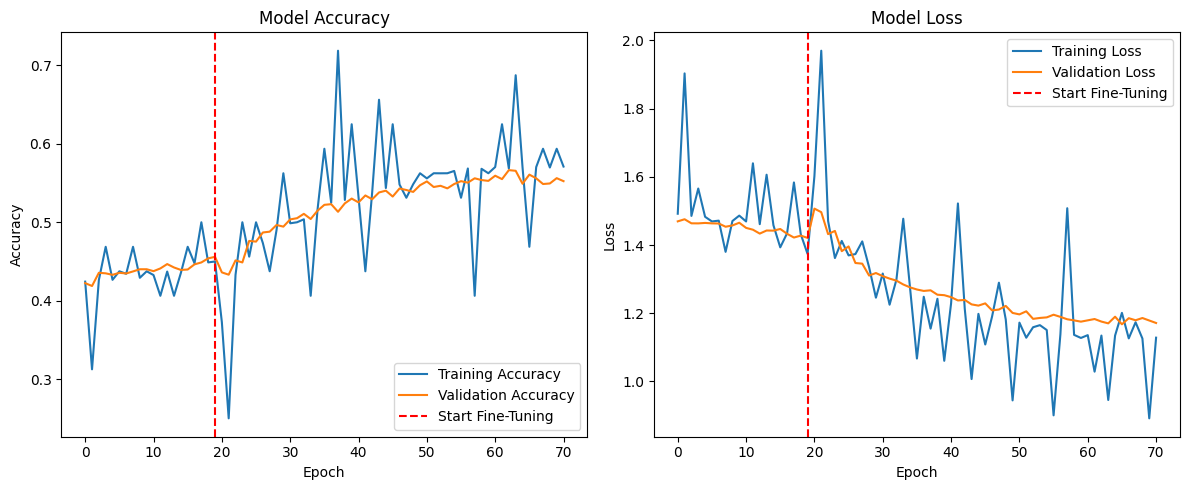

In [15]:
# Combine the history from both training phases
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Plot the combined training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Add a vertical line to show where fine-tuning started
plt.axvline(len(history.epoch)-1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot the combined training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# Add a vertical line to show where fine-tuning started
plt.axvline(len(history.epoch)-1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()